In [2]:
import os
# import nglview as nv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

# import seaborn as sns
# from hilbertcurve.hilbertcurve import HilbertCurve
from scipy.ndimage import gaussian_filter
from scipy.stats import entropy

def cgenff_reader(filename):
  with open(filename) as file1:
    lst = list(filter(lambda i: re.match(r"^ATOM.*!", i), file1))
  theatom  = [i.strip("\n").split()[1] for i in lst]
  atomtype = [i.strip("\n").split()[2] for i in lst]
  charge   = [float(i.strip("\n").split()[3]) for i in lst]
  penalty  = [float(i.strip("\n").split()[-1]) for i in lst]
  return {"name":theatom, "type":atomtype, "charge":charge, "penalty":penalty}
    
def lig_xml(dic, write_file=False, source=False):
  root = ET.Element('ForceField')
  info = ET.SubElement(root, 'Info')
  info_date = ET.SubElement(info, "date")
  info_date.text = str(date.today())
  if source != False: 
    info_file = ET.SubElement(info, 'source')
    info_file.text = source

  data_lig = ET.SubElement(root, 'LIG')
  for i in range(len(dic["name"])):
    tmpattrib={
      "name":dic["name"][i], 
      "type": dic["type"][i], 
      "charge": str(dic["charge"][i]), 
      'penalty': str(dic["penalty"][i]),
    }
    tmpatom = ET.SubElement(data_lig, 'ATOM', attrib = tmpattrib)

  ligxml_str = ET.tostring(root , encoding="unicode")
  dom = minidom.parseString(ligxml_str)
  ligxml_str = dom.toprettyxml()

  if write_file != False :
    with open(write_file, "w") as file1: 
      file1.write(ligxml_str)
  return ligxml_str

class ffreader:
  def __init__(self, ff):
    self.domff = minidom.parse(ff)
    self.residues = self.domff.getElementsByTagName("Residue")
    self.residuemap = {
      "TIP3":"T3P",
      "HOH":"T3P",
      "WAT":"T3P",
      'HID':"HSD",
      'HIE':"HSE",
      'HIP':"HSP", 
      "CYX":"CYS",
    }
    self.map_resnames()

  def map_resnames(self):
    reslst = [i.getAttribute("name") for i in self.residues]
    for i in reslst: 
      if i in self.residuemap.keys():
        print(f"mapping residue {i}")
        idx = reslst.index(i)
        self.residues[idx].setAttribute("name", self.residuemap[i])
    self.residues = self.domff.getElementsByTagName("Residue")

  def format_resname(self, resname):
    resname = resname.upper()
    if resname in self.residuemap.keys():
      resname = self.residuemap[resname]
    return resname

  def format_atomname(self, retdic):
    keys = retdic.keys()
    values = retdic.values()
    return {i:j for i,j in zip(keys, values)}

  def getTypes(self, resname):
    # TODO: possible changes to map the residue name 
    # TODO: map HIS/HIE/HID, CYX, etc
    resname = self.format_resname(resname);
    for i in self.residues: # self.domff.getElementsByTagName("Residue"):
      if i.attributes["name"].value == resname:
        names = [_.attributes["name"].value for _ in i.getElementsByTagName("Atom")]
        types = [_.attributes["type"].value for _ in i.getElementsByTagName("Atom")]
        break
    ret = {i:j for i,j in zip(names, types)}
    return self.format_atomname(ret)

  def getCharges(self, resname):
    # TODO: possible changes to map the residue name 
    # TODO: map HIS/HIE/HID, CYX, etc
    resname = self.format_resname(resname); 
    for i in self.residues: 
      if i.attributes["name"].value == resname:
        names = [_.attributes["name"].value for _ in i.getElementsByTagName("Atom")]
        charges = [_.attributes["charge"].value for _ in i.getElementsByTagName("Atom")]
        break
    ret = {i:float(j) for i,j in zip(names, charges)}
    return self.format_atomname(ret)

  def getAtomCharge(self, resname, atomname):
    resname = self.format_resname(resname); 
    found_res = False
    for i in self.residues: 
      if i.attributes["name"].value == resname:
        names = [_.attributes["name"].value for _ in i.getElementsByTagName("Atom")]; 
        charges = [_.attributes["charge"].value for _ in i.getElementsByTagName("Atom")]; 
        found_res = True;
        break
    if found_res: 
      found_atom = False;
      for i,j in zip(names, charges):
        if i == atomname: 
          return float(j); 
          found_atom = True; 
          break
      if not found_atom:
        print(f"Found the residue {resname}, however, Not found the atom {atomname}"); 
        return 0; 
    else : 
      print(f"Not found the residue {resname}")
      return 0; 

  def addFF(self, ff, waitlist=[]):
    # use minidom purely
    residues_oldff = self.domff.getElementsByTagName('Residues')
    newff = minidom.parse(ff)
    residues_newff = newff.getElementsByTagName('Residue')
    for i in residues_newff:
      if len(waitlist) == 0 or i.getAttribute("name") in waitlist:
        residues_oldff[0].appendChild(i)
      else: 
        pass
    self.residues = self.domff.getElementsByTagName("Residue")
    self.map_resnames()

In [5]:
import time
import pickle 
import numpy as np 
import pytraj as pt 
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter
from scipy.stats import entropy

from BetaPose import utils

# Forcefield and xml related functions
import re
from xml.dom import minidom
import xml.etree.ElementTree as ET

tmptop = pt.load("./tests/featurizer_test1.pdb")
def getprotein(traj):
  reslst = []
  for i in traj.top.atoms:
    if i.name=="CA":
      reslst.append(i.resid+1)
  mask = ":"+",".join([str(i) for i in reslst])
  return traj.top.select(mask)

  
a = utils.getprotein(tmptop)
# print((a+1).astype(str).tolist()+a.tolist())



In [127]:
import pickle
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import nglview as nv 
import pytraj as pt
%matplotlib
# %nglview
class feature_3d_reader:
  def __init__(self, pickleFile):
    # Generate the 2D/3D hilbert curve
    with open(pickleFile, "rb") as file1:
      featuredic = pickle.load(file1)
      print(featuredic.keys()); 
      self.distances = featuredic["distances"]; 
      self.length3D  = featuredic["length3D"];
      self.points3D  = featuredic["points3D"]; 
      self.index3D   = featuredic["index3D"];
      self.features  = featuredic["features"];

      self.atom_groups = featuredic["atom_groups"]; 
      self.frameList = featuredic["frameList"]
      self.frameNr   = featuredic["frameNr"]
      if "element" in self.features:
        self.atom_mass  = featuredic["atom_mass"]
        self.norm_mass  = featuredic["norm_mass"]
        self.gauss_mass = featuredic["gauss_mass"]
      if "entropy" in self.features:
        self.entropy = featuredic["entropy"]
        self.gauss_entropy = featuredic["gauss_entropy"]
      if "charge" in self.features:
        self.atom_charge  = featuredic["atom_charge"]; 
        self.gauss_charge = featuredic["gauss_charge"]; 
        
  def selectData(self, maintype, select_group, subtype="gauss"):
    if maintype == "element":
      if subtype == "atom":
        data = self.atom_mass[select_group]; 
      elif subtype == "norm":
        data = self.norm_mass[select_group]; 
      elif subtype == "gauss": 
        data = self.gauss_mass[select_group]; 
      else: 
        print(f"Not Found the subtype {subtype}"); 
        data = self.gauss_mass[select_group]; 
    elif maintype == "entropy":
      if subtype == "gauss":
        data = self.gauss_entropy; 
      else:
        data = self.entropy; 
    elif maintype == "charge":
      if subtype == "atom":
        data = self.atom_charge[select_group]; 
      elif subtype == "gauss": 
        data = self.gauss_charge[select_group]; 
      else: 
        print(f"Not Found the subtype {subtype}"); 
        data = self.gauss_charge[select_group]; 
    return data
  
  def scatter3D(self, maintype, select_group, indice=0, subtype="gauss", cmap="Blues", threshold=0.1):
    thedata = self.selectData(maintype, select_group, subtype=subtype);
    if maintype == "element":
      thedata = thedata[indice]

    fig = plt.figure(); 
    ax = fig.add_subplot(projection='3d'); 
    plt.ion(); 

    thecmap = cm.get_cmap(cmap)
    print(thedata.shape)
    for i in self.distances: 
      theindex = tuple(self.index3D[i]); 
      theposition = self.points3D[i]; 
      v = thedata[theindex]
      thecolor = thecmap(v)
      # print(f"point: {i}, value: {v}, color: {thecolor}")
      if v > threshold:
        ax.scatter(*theposition, color=thecolor)

  def gen_pdbstr(self, coordinates, elements=None, bf=[]):
    if elements == None: 
      elements = ["Du"]*len(coordinates)
    if len(coordinates) != len(bf):
      print("length not aligned")
    pdbline = ""
    tempstr = "ATOM      1  Du  TMP     1       0.000   0.000   0.000  1.00  0.00";
    coordinates = np.round(coordinates, decimals=3)
    for i in range(len(coordinates)):
      if len(bf) != 0: 
        bfval = bf[i]
      else: 
        bfval = 0.00
      point = coordinates[i]; 
      elem  = elements[i]; 
      tmpstr = "".join(["{:>8}".format(i) for i in point]); 
      tmpstr = "".join([f"{i:>8}" for i in point]); 
      thisline = f"ATOM  {i:>5}  {elem:<3}{tempstr[16:30]}{tmpstr}{tempstr[54:60]}{round(bfval,2):>6}\n"
      pdbline += thisline
    return pdbline

  def filter_coor(self, maintype, select_group, threshold, mode="gt", indice=0, subtype="gauss"):
    thedata = self.selectData(maintype, select_group, subtype=subtype);
    if maintype == "element" or maintype == "charge":
      thedata = thedata[indice]
    if mode == "gt":
      status = thedata > float(threshold)
    elif mode == "lt":
      status = thedata < float(threshold)
    elif mode == "mid":
      threshold1 = float(threshold.split(",")[0])
      threshold2 = float(threshold.split(",")[1])
      status1 = thedata >= threshold1
      status2 = thedata <= threshold2
      status = status1 * status2
    elif mode == "out":
      threshold1 = float(threshold.split(",")[0])
      threshold2 = float(threshold.split(",")[1])
      status1 = thedata < threshold1
      status2 = thedata > threshold2
      status = np.logical_or(status1, status2)
    filtered = thedata[status]
    print(f"there are {np.count_nonzero(status)} non-zero values")
    print(f"Filtered data: mean:{np.mean(filtered):2f}, Std:{np.std(filtered):2f}, Max:{np.max(filtered):2f}, Min:{np.min(filtered):2f}")
    coorlist = []
    for i in self.distances: 
      theindex = tuple(self.index3D[i]); 
      if status[theindex] == True:
        coorlist.append(self.points3D[i])
    return np.array(coorlist), filtered

  def write_pdb(self, pdblines, pdbfile="./test.pdb"):
    with open(pdbfile, "w") as file1:
      file1.write(pdblines)
    return pdbfile
        
reader = feature_3d_reader("test_featurizer_3D.pkl")

# print(reader.selectData("charge", "ligand", subtype="atom"))

points, filtered_vals = reader.filter_coor("charge", "ligand", "-0.05,0.05", indice=0, mode = "out", subtype="atom")
print(points.shape, len(filtered_vals))
tmppdb = reader.gen_pdbstr(points, bf=filtered_vals)
reader.write_pdb(tmppdb)
viewer = nv.show_text(tmppdb)

traj1 = pt.load("test_featurizer.pdb")

def sel_conv(traj, mask):
  return f"@{','.join(traj.top.select(mask).astype(str))}"


viewer.add_component("test_featurizer.pdb")
viewer[0].clear_representations()
viewer[0].add_representation("line", color="bfactor", opacity=0.6, pointSize=0.7)
viewer[1].clear_representations()
viewer[1].add_representation("cartoon", selection="protein", color="#bbe1fa")
# viewer[1].add_representation("licorice", selection="protein")
selstr = sel_conv(traj1, ":113-120")
viewer[1].add_representation("line", selection=selstr, radius=4, zOffset=0, xOffset=0.5,yOffset=0.5)
selstr = sel_conv(traj1, ":LIG")
viewer[1].add_representation("ball+stick", selection=selstr)
viewer

# reader.scatter3D("entropy", "all", subtype="gauss", cmap="Reds", threshold=0.3); 



Using matplotlib backend: Qt5Agg
dict_keys(['frameNr', 'frameList', 'atom_groups', 'distances', 'length3D', 'index3D', 'points3D', 'features', 'atomic_names', 'atomic_number', 'atom_mass', 'norm_mass', 'gauss_mass', 'entropy', 'gauss_entropy', 'atom_charge', 'gauss_charge'])
there are 651 non-zero values
Filtered data: mean:-0.010184, Std:0.387488, Max:0.500000, Min:-0.773000
(651, 3) 651


NGLWidget()

In [ ]:
REPRESENTATION_NAME_PAIRS = [
    ('axes', 'axes'),            # Shows the three pairs of ellipse axes
    ('principal_axes', 'axes'),  # Not work well. Should be used in another way
    ('point', 'point'),          # Cubic point
    ('line', 'line'),            # Dummy atoms as cross, other structures are normal
    ('rope', 'rope'),            # A normal representation on ONLY protein structure 
    ('tube', 'tube'),            # A normal representation on ONLY protein structure (relative thin)
    ('trace', 'trace'),          # A normal representation on ONLY protein structure (very thin line)
    ('label', 'label'),          # Very interesting labels
    ('slice', 'slice'),          # Not work well. Should be used in another way
    ('unitcell', 'unitcell'),    # Unit cell of the PDB
    ('cartoon', 'cartoon'),      # A normal representation on ONLY protein structure 
    ('licorice', 'licorice'),    # A normal representation on ALL structure 
    ('distance', 'distance'),    # Not work well. Should be used in another way
    ('ribbon', 'ribbon'),        # A normal representation on ONLY protein structure 
    ('surface', 'surface'),      # SURFACE
    ('backbone', 'backbone'),    # A normal representation on ONLY protein structure 
    ('contact', 'contact'),      # Hydrogen bond interaction 
    ('hyperball', 'hyperball'),  # A normal representation on ALL structure 
    ('rocket', 'rocket'),        # A SPECIAL representation on ONLY protein structure 
    ('helixorient', 'helixorient'), # A SPECIAL representation on ONLY protein structure and ONLY alpha-Helix
    ('simplified_base', 'base'), # Not work well. Should be used in another way
    ('spacefill', 'spacefill'),  # SPHERE
    ('ball_and_stick', 'ball+stick'),  # BALL+STICK
]

In [178]:
from scipy.stats import entropy
def get_entropy(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return entropy(counts)
    
# lst1 = [1500, 8, 4, 3, 54]
lst1 = [0, 0, 0, 3, 0, 0, 0, 4, 3, 2 , 0, 0, 0, 3, 0]
lst2 = [i for i in set(lst1)]
print(get_entropy(lst1))
print(get_entropy(lst2))

0.953271014705891
1.3862943611198906


In [152]:
x=reader.gauss_entropy.reshape((-1,8000)).squeeze()
bins = np.linspace(0,0.7,15)
print(bins)
def plt_hist(data, n_bins):
    fig, ax = plt.subplots(1, 1, sharey=True, tight_layout=True)
    N, bins, patches = ax.hist(data, bins=n_bins)
    return fig, ax, N, bins, patches
plt_hist(x, n_bins=bins)

NameError: name 'reader' is not defined

Calculating pairwise distance
Pairing:   N1( 41106) -    O(   632)
Pairing:   C1( 41107) -    O(   632)
Pairing:   C4( 41108) -    N(  3123)
Pairing:   O1( 41109) -    N(  3138)
Pairing:   O2( 41110) -   CB(  3115)
Pairing:   C2( 41111) -    O(   632)
Pairing:   C3( 41112) -    O(  1837)
Pairing:   S1( 41113) -    O(  1856)
Pairing:   C5( 41114) -    O(  1856)
Pairing:   C6( 41115) -    O(   632)
Pairing:   O3( 41116) -   CA(   630)
Pairing:   C9( 41117) -   CA(   630)
Pairing:   N2( 41118) -   CA(   630)
Pairing:  C14( 41119) -   CB(   985)
Pairing:   N6( 41120) -    N(   979)
Pairing:  C13( 41121) -    O(  1480)
Pairing:  C10( 41122) -   CB(   985)
Pairing:   N3( 41123) -   CB(   985)
Pairing:  C11( 41124) -   CB(   985)
Pairing:   N5( 41125) -    N(  1502)
Pairing:  C12( 41126) -    N(  1502)
Pairing:   N4( 41127) -    N(  1502)
Pairing:   C8( 41128) -   CA(   630)
Pairing:   O5( 41129) -    N(   979)
Pairing:   C7( 41130) -   CA(   648)
Pairing:   O4( 41131) -   CA(   648)
The foll

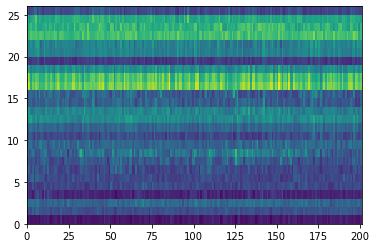

In [8]:
from BetaPose import utils, cluster
import pytraj as pt 
import numpy as np 
import matplotlib.pyplot as plt 

a="/home/miemie/Dropbox/Documents/BetaPose/tests/featurizer_test1.pdb"; 
b="/home/miemie/Dropbox/Documents/BetaPose/tests/featurizer_test1.nc"; 
traj = pt.load(b, top=a); 
traj.top.set_reference(traj[0]); 
pdist, y = utils.PairwiseDistance(traj, ":LIG&!@H=", ":LIG<@6&!:LIG&@C,CA,CB,N,O",use_mean=True); 

plt.pcolormesh(pdist)
clusters = cluster.ClusterAgglomerative(pdist, 10)
cluster_rand = cluster.RandomPerCluster(clusters, number=1)
print("The following frames are selected", cluster_rand)
# cluster.RMSDClusters(clusters, a, b); 
# cluster.RMSDGroup(cluster_rand, a, b); 




(26, 201)
[0 0 3 ... 2 3 2] 201


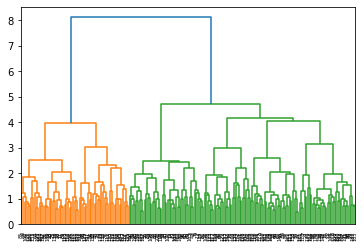

In [6]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

pdist

# pair_dist_sel = np.concatenate((dist_details["lig_atomids"], dist_details["pro_atomids"]))
# selrms = pt.rmsd(traj, mask="@"+",".join(pair_dist_sel.astype(str)))

# print(pair_dist_sel, len(pair_dist_sel))
# print(selrms)

clusterNr = 10
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(pdist.T, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=clusterNr, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict([pdist[:,i] for i in range(len(pdist.T))])
bins = np.unique(y_hc)
print(pdist.shape)
print(y_hc, len(y_hc))

In [27]:
import tmtools
from Bio.PDB.Polypeptide import three_to_one
print(dir(tmtools))

from tmtools.io import get_structure, get_residue_data
get_structure("/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/1ctu/1ctu_protein.pdb")
def sanitizeres(seq):
  mapping = {
    "HSD":"HIS","HSE":"HIS","HSP":"HIS","HID":"HIS","HIE":"HIS","HIP":"HIS",
  }
  outlst = []
  for i in seq: 
    if i in mapping.keys():
      outlst.append(mapping[i])
    else: 
      outlst.append(i)
  return outlst
def getseq(traj1, mask=":*"):
  cas = traj1.top.select(f"@CA&{mask}")
  caatoms = np.array([*traj1.top.atoms])[cas]
  resids = np.array([i.resid for i in caatoms])
  residues = np.array([*traj1.top.residues])[resids]
  res_three = sanitizeres([i.name for i in residues]); 
  res_one = [three_to_one(i) for i in res_three]; 
  return "".join(res_one)
def GetCACoord(traj1, idx, mask=":*"):
  return traj.xyz[idx][traj.top.select(f"@CA&{mask}")]
def GetMeanCACoord(traj1, mask=":*"):
  return np.mean(traj.xyz, axis=0)[traj.top.select(f"@CA&{mask}")]
  
print(GetMeanCACoord(traj).shape)

theseq = getseq(traj, ":LIG<:6")
print(theseq)
print(traj.xyz.shape)
tm_scores=[]
for i in range(len(traj.xyz)):
  tmout = tmtools.tm_align(GetMeanCACoord(traj, ":LIG<:6"), GetCACoord(traj,i, ":LIG<:6"), theseq,theseq)
  tm_scores.append(tmout.tm_norm_chain1)
tm_scores=np.array(tm_scores)
print(np.std(tm_scores))
clust_tm = ClusterAgglomerative(tm_scores.reshape(1, -1) , 10)
print(clust_tm)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_bindings', 'io', 'tm_align']
(221, 3)
DIGCGYGGLLEIRVSNAMKFLFPDHWITEEGK
(201, 41152, 3)
0.02903432057592061
[8 1 1 ... 1 7 6]


In [155]:
def ClusterAgglomerative(pdist, clusternr):
  """
    Cluster the distance values to {clusternr} classes
    [0 0 3 ... 2 3 2]  # 10 classes
  """
  hc = AgglomerativeClustering(n_clusters=clusternr, affinity = 'euclidean', linkage = 'ward'); 
  y_hc = hc.fit_predict(pdist.T); 
  return y_hc

def RandomPerCluster(cluster, number=1):
  """
    Choose {number} data points from each cluster
  """
  retlst = []
  for gp in np.unique(cluster):
    gp1 = [i for i,j in enumerate(cluster) if j == gp]; 
    randidx = np.random.choice(gp1, number)
    if number ==1: 
      retlst.append(int(randidx))
    elif number >1: 
      retlst += list(randidx)
  retlst.sort()
  return retlst

def RMSDClusters(cluster, pdbfile, trajfile):
  """
    Caluclate the RMSD values of the each clusters
    Examine the quality of clusters
  """
  rmsdlst=[]
  for gp in np.unique(cluster):
    gp1 = [i for i,j in enumerate(cluster) if j == gp]; 
    traj1 = pt.load(trajfile, top=pdbfile, frame_indices=gp1);
    traj1.superpose("@CA")
    print(f"Cluster {gp}: Selected frames: {len(gp1)} frames "); 
    #     print("==>", tm_scores[gp1])
    #     print("==>", np.std(tm_scores[gp1]))
    gprmsd = pt.rmsd(traj1, ":LIG&!@H="); 
    gpgyr = pt.radgyr(traj1, ":LIG&!@H="); 
    print(f"RMSD: {gprmsd.mean()}-{gprmsd.std()}\nROG: {gpgyr.mean()}-{gpgyr.std()}")
    rmsdlst.append(gprmsd.mean())
  print(f"Average RMSD: {np.mean(rmsdlst)}\n")
  return rmsdlst

def RMSDGroup(frames, pdbfile, trajfile):
  """
    Caluclate the RMSD values of certain frames 
    Examine the quality of clusters
  """
  traj1 = pt.load(trajfile, top=pdbfile, frame_indices=frames);
  rmsds = pt.rmsd(traj1, ":LIG&!@H="); 
  print(f">>> RMSD: {rmsds.mean()}-{rmsds.std()}\n")
  return rmsds
  

    
a="/home/miemie/Dropbox/Documents/BetaPose/tests/featurizer_test1.pdb"; 
b="/home/miemie/Dropbox/Documents/BetaPose/tests/featurizer_test1.nc";
x = ClusterAgglomerative(pdist, 10)
# x = clust_tm; 
# print([i for i in x])

RMSDClusters(x,a,b)
randnr = np.random.choice(np.arange(len(x)), size=10, replace=False)
randnr.sort()
print("Ramdom frames", [i for i in randnr])
RMSDGroup(randnr,a,b)
print("All frames: ")
RMSDGroup(range(len(x)),a,b)
print("Each from one cluster: ")
cluster_rand = RandomPerCluster(x, number=1)
print(cluster_rand)
RMSDGroup(cluster_rand,a,b)


NameError: name 'pdist' is not defined

In [68]:
from BetaPose import cluster
cluster.ClusterAgglomerative(pdist, 10)
cluster.RMSDClusters(x,a,b)

NameError: name 'np' is not defined

In [154]:
lst = []
for i in range(100): 
  randnr = np.random.choice(np.arange(len(x)), size=10, replace=False)
  randnr.sort()
  print("Ramdom frames", [i for i in randnr])
  rmsds = RMSDGroup(randnr,a,b)
  lst.append(rmsds.mean())
print(np.mean(lst))
plt.scatter(clust_tm, tm_scores)
# tm_scores=np.array(tm_scores)
# clust_tm

NameError: name 'x' is not defined

In [52]:
############### Put these to the test.py and further work. 

class TRAJ: 
  def __init__(self, trajfile, pdbfile):
    self.traj = pt.load(trajfile, top=pdbfile); 
    self.traj.top.set_reference(self.traj[0])
    
  def cluster_pairwise(self, mask, **kwarg): 
    if "countermask" in kwarg.keys():
      countermask = kwarg["countermask"]
      pdist, y = utils.PairwiseDistance(self.traj, f"{mask}&!@H=", f"{countermask}&!@H=", use_mean=True);
    else: 
      pdist, y = utils.PairwiseDistance(self.traj, f"{mask}&!@H=", f"{mask}<@6&!{mask}&@C,CA,CB,N,O", use_mean=True);
    clusters = cluster.ClusterAgglomerative(pdist, 10); 
    cluster_rand = cluster.RandomPerCluster(clusters, number=1); 
    self.frames = cluster_rand; 
    return self.frames
    
  def cluster_rmsd(self):
    self.traj = self.traj; 
    
  def slicetraj(self, frameindices):
    frameindices = np.array(frameindices).astype(int)
    self.traj = pt.Trajectory(self.traj[frameindices])
    
  def cluster(self, method="", **kwarg):
    if len(method) == 0:
      self.cluster_pairwise(**kwarg); 
    elif (method == "distance"): 
      pass
    return self.frames
  
  def updatesearchlist(self, mask, cutoff):
    self.searchlist = self.traj.top.select(f"{mask}<@{cutoff}"); 
    return self.searchlist;
  
  def test(self, coordinates, elements=[]):
    if len(elements) == 0: 
      elements = ["H"] * len(coordinates); 
      
#     thexyz = np.array([self.traj.xyz[0]])
#     newtraj = pt.Trajectory(xyz=thexyz, top=self.traj.top); 
#     print(newtraj); 
#     print(self.traj.top.box)
    newframe = pt.Frame(self.traj[0])
    newtop = pt.Topology(self.traj.top)
    
    resids = [i.index for i in self.traj.top.residues]
    maxid = resids[-1]
    print(f"Before: {newframe.xyz.shape}")
    for i, c in enumerate(coordinates): 
      therid = (maxid+i+2); 
      print(therid, c)
      
      theatom = pt.Atom(name='CL', charge=0.04, mass=17.0, resname="BOX",type="H", resid=therid);
      theres  = pt.Residue(name='BOX', resid=therid)
      
      newtop.add_atom(theatom, theres)
#       newtop.add_residue(theres)
      newframe.append_xyz(np.array([c]).astype(np.float64))
    print(f"After addition newframe {newframe.xyz.shape}, {newtop.n_atoms}")
    thexyz = np.array([newframe.xyz])
    newtraj = pt.Trajectory(xyz=thexyz, top=newtop)

#     newtraj[0].set_nobox()
    self.testtraj = newtraj; 
    pt.write_traj("/tmp/test.pdb", newtraj, overwrite=True)
    
    
  
########################################################
class TrajectoryLoader: 
  def __init__(self, trajs, tops):
    if isinstance(trajs, str):
      self.trajs = [trajs]; 
      self.tops  = [tops]; 
    elif isinstance(trajs, list):
      self.trajs = trajs; 
      self.tops  = tops; 
  def __iter__(self):
    return self.__loadtrajs(self.trajs, self.tops); 
  
  def __loadtrajs(self, trajs, tops):
    for traj, top in zip(trajs, tops):
      yield TRAJ(traj, top)


class feature:
  def __init__(self):
    pass
  
  def __display__(self):
    print(self.traj); 
    
  def __str__(self):
    return self.__class__.__name__
    
  def hook(self, featurizer):
    self.featurizer = featurizer
    self.top = featurizer.traj.top
    
  def run(self, trajectory):
    """
      update interval
      self.traj.superpose arguments. 
      updatesearchlist arguments. 
    """
    self.traj = trajectory.traj; 
    self.feature_array=[]; 
    for index, frame in enumerate(self.traj):
      theframe = self.traj[index]; 
      if index % 1 == 0:
        refframe = pt.Frame(theframe); 
        self.searchlist = trajectory.updatesearchlist(":MDL,LIG" , 18); 
        self.traj.top.set_reference(theframe); 
        self.traj.superpose(ref=refframe, mask="@CA")
        
      feature_frame = self.forward(self.traj[index]); 
      self.feature_array.append(feature_frame); 
    self.feature_array = np.array(self.feature_array); 
    return self.feature_array; 
  

class massfeature(feature):
  def __init__(self):
    super(massfeature, self).__init__()
  def forward(self, frame): 
    """
      1. Get the atomic feature
      2. Update the feature 
    """
    pdb_atomic_numbers = np.array([i.atomic_number for i in self.top.atoms]).astype(int); 
    thisxyz = frame.xyz; 
    selxyz = thisxyz[self.searchlist]; 
    self.atom_mass = []; 
    
    cand_status = (distance_matrix(selxyz, self.featurizer.center.reshape(1,3)) <= self.featurizer.cutoff); 
    cand_status = cand_status.squeeze(); 
    cand_xyz    = selxyz[cand_status]; 
    cand_distmatrix = distance_matrix(self.featurizer.points3d, cand_xyz)
    cand_diststatus = cand_distmatrix < 1.75
    
    cand_index  = self.searchlist[cand_status]; 
    mins = np.min(cand_distmatrix, axis=1); 
    idx_lst = [np.where(cand_distmatrix[m] == mins[m])[0][0] if np.any(cand_diststatus[m,:]) else -1 for m in range(len(mins))]; 
    candlst = [cand_index[m] if m>=0 else -1 for m in idx_lst]; 
    
    atom_mass_frameN = [pdb_atomic_numbers[m] if m > 0 else 0 for m in candlst];
    atom_mass_frameN = self.featurizer.points_to_3D(atom_mass_frameN); 
    return np.array(atom_mass_frameN); 

import pytraj as pt 
import numpy as np
trajs = ["/home/yzhang/Documents/Personal_documents/BetaPose/C022simtemp3/C022simtemp3_TRJ.nc"]
tops  = ["/home/yzhang/Documents/Personal_documents/BetaPose/C022simtemp3/C022simtemp3_PDB.pdb"]
traj = TRAJ(trajs[0], tops[0])
x = np.arange(12,72).reshape((-1,3))
# print(x)
traj.test(x)
print(dir(traj.traj.top))
print([i for i in traj.testtraj.top.atoms][-100:])
print([i for i in traj.testtraj.top.residues][-100:])


Before: (48534, 3)
5256 [12 13 14]


TypeError: __cinit__() got an unexpected keyword argument 'n_atoms'

In [2]:
import pytraj as pt 
import numpy as np 
import time
from BetaPose import utils, cluster
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance_matrix
from scipy.stats import entropy
import datetime
# from BetaPose.test import TRAJ, TrajectoryLoader

# Reload the print function and log the print functions
import builtins
def logit(function):
  def adddate(arg):
    timestamp = datetime.datetime.now().strftime('%y-%m-%dT%H:%M:%S')
    builtins.print(f"{timestamp}: ", end="")
    function(arg)
  return adddate

@logit
def print(*arg, **kwarg):
  builtins.print(*arg, **kwarg)

########################################################
class featurizer_3d:
  def __init__(self, parms):
    self.parms = parms
    try: 
      parms2check = ["GRID_POINTS", "BOX_LENGTH", "CUTOFF", "MASK_INTEREST", "MASK_ENVIRONMENT"]
      for parm in parms2check:
        parms[parm]; 
    except: 
      print(f"Please define the keyword <{parm}> in your parameter set")
      return
    
    self.__init_settings(parms); 
    self.FEATURES = []; 
    
  def __str__(self):
    finalstr = f"Feature Number: {len(self.FEATURES)}; \n"
    for i in self.FEATURES:
      finalstr += f"Feature: {i.__str__()}\n"
    return finalstr
    
  def __translation(self, **kwarg):
    """
      Apply a translational movement to the cell box;
    """
    # Re-calculate the box center
    if "CENTER_MASK" in kwarg.keys():
      diff = self.__boxcenter - pt.center_of_mass(self.traj, mask=self.__mask)[0]; 
      self.__points3d -= diff; 
      self.__boxcenter = np.squeeze(np.mean(self.__points3d, axis = 0)); 
    elif "CENTER" in kwarg.keys():
      diff = self.__boxcenter - np.array(kwarg["CENTER"]);
      self.__points3d -= diff; 
      self.__boxcenter = np.squeeze(np.mean(self.__points3d, axis = 0)); 
    
    # calculate a center and update box   
    if "BOX_SHIFT" in kwarg.keys():
      self.__points3d += np.array(kwarg["BOX_SHIFT"]); 
      self.__boxcenter = np.squeeze(np.mean(self.__points3d, axis = 0)); 
    
    
  def __init_settings(self, parms):
    """
      Initialize important parameters/settings
      # self.__voxellength, self.__distances, self.__indexes3d, self.__points3d, self.__boxcenter 
    """
    self.__pointnr = int(parms["GRID_POINTS"]); 
    self.__length  = float(parms["BOX_LENGTH"]); 
    self.updatebox()
    self.__searchcutoff = float(parms["CUTOFF"]); 
    if isinstance(parms["MASK_INTEREST"], str):
      self.__mask = parms["MASK_INTEREST"]
    else: 
      print("MASK_INTEREST is not a string. It should be a iterable object")
      
    if isinstance(parms["MASK_ENVIRONMENT"], str):
      self.__maskenv = parms["MASK_ENVIRONMENT"]
    else: 
      print("MASK_ENVIRONMENT is not a string. It should be a iterable object")
  
  @property
  def points3d(self):
    return self.__points3d
  @property
  def center(self):
    return np.array(self.__boxcenter)
  @property
  def cutoff(self):
    return self.__searchcutoff
    
  def updatebox(self):
    # print("Setting the box")
    self.__voxellength = self.__length / self.__pointnr; 
    self.__distances = np.array(range(self.__pointnr ** 3)).astype(int); 
    self.__indexes3d = self.get_points().astype(int); 
    self.__points3d = (self.get_points() * self.__voxellength).astype(np.float32); 
    self.__boxcenter = np.squeeze(np.mean(self.__points3d, axis = 0)); 
    
  def get_point_by_distance(self, point, length):
    d0 = int(point/length**2)
    d1 = int((point - d0*length**2)/length)
    d3 = int(point - d0*length**2 - d1*length)
    return [d0, d1, d3]
  
  def get_points(self):
    x=[]; 
    for i in range(self.__pointnr**3):
      x.append(self.get_point_by_distance(i, self.__pointnr))
    return np.array(x).astype(int)
    
  def register_feature(self, feature):
    self.FEATURES.append(feature)
    
  def setboxlength(self, length):
    self.__length = float(length); 
    self.updatebox(); 
    
  def scaleboxlength(self, scalefactor):
    self.__length *= scalefactor; 
    self.updatebox(); 
  
  def points_to_3D(self, thearray, dtype=float):
    if len(self.__distances) != len(thearray):
      print("Cannot match the length of the array to the 3D cuboid"); 
      return np.array([0])
    template  = np.zeros((self.__pointnr, self.__pointnr, self.__pointnr)).astype(dtype);
    for ind in self.__distances:
      array_3Didx = tuple(self.__indexes3d[ind]); 
      template[array_3Didx] = thearray[ind]
    return template
  
  
  def write_box(self, pdbfile, elements=[], bfactors=[]):
    if len(elements) == 0: 
      elements = ["Du"] * len(self.__distances); 
    if len(bfactors) == 0: 
      bfactors = [0.00] * len(self.__distances); 
    
    pdbline = ""
    template = "ATOM      1  Du  TMP     1       0.000   0.000   0.000  1.00  0.00";
    coordinates = np.round(self.__points3d, decimals=3)
    
    for i in self.__distances:
      point = self.__points3d[i]; 
      elem  = elements[i]; 
      bfval = bfactors[i];
      tmpstr = "".join(["{:>8}".format(i) for i in point]); 
      tmpstr = "".join([f"{i:>8}" for i in point]); 
      thisline = f"ATOM  {i:>5}  {elem:<3}{template[16:30]}{tmpstr}{template[54:60]}{round(bfval,2):>6}\n"
      pdbline += thisline
      
    with open(pdbfile, "w") as file1:
      file1.write(pdbline)
    return pdbline
  
  def run_iter(self, trajloader):
    print("Iterate through all trajectories")
    for traj in trajloader:
      print(f"{self.run_iter.__name__}: Frame number before trajectory slicing: {len(traj.traj)}")
      indices_after_cluster = traj.cluster(mask=self.__mask); 
      traj.slicetraj(indices_after_cluster); 
      print(f"{self.run_iter.__name__}: Frame number after trajectory slicing: {len(traj.traj)} ; indices kept: {indices_after_cluster}", )
      self.traj = traj.traj; 
      
      # One translate operation in one trajectory only. 
      self.__translation(**self.parms); 
      print("Featurize the trajectory ......"); 
      for f in self.FEATURES:
        # Hook the featurizer to the individual feature functions and let it access the featurizer settings
        f.hook(self); 
        arr = f.run(traj); 
        print(arr.shape)
        print(f"Finished the featuization of the {f}")
        
        
# Home PC      
trajs = ["/home/miemie/storage/WDRed/project_METTL1/batch3/example_pdbs/C013simtemp4_job_001_stride10.nc" , 
         "/home/miemie/storage/WDRed/project_METTL1/batch3/example_pdbs/C013simtemp4_job_002_stride10.nc"
        ]
tops = ["/home/miemie/storage/WDRed/project_METTL1/batch3/example_pdbs/C013simtemp4_job_001_top.pdb",
        "/home/miemie/storage/WDRed/project_METTL1/batch3/example_pdbs/C013simtemp4_job_002_top.pdb"
       ]

# Work PC
trajs = ["/home/yzhang/Documents/Personal_documents/BetaPose/C022simtemp3/C022simtemp3_TRJ.nc"]
tops  = ["/home/yzhang/Documents/Personal_documents/BetaPose/C022simtemp3/C022simtemp3_PDB.pdb"]

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "GRID_POINTS" : 16,        # Unit: 1 (Number of lattice in one dimension)
  "BOX_LENGTH" : 10,        # Unit: Angstorm (Need scaling)
  "BOX_SHIFT" : [1,2,3],    # Either CENTERMASK, CENTER or CELL_SHIFT (mask>center>shift) 
  # CENTERING SETTINGS
  #   "CENTER" : [4,15,6],        # Align the box center to an absolute XYZ coordinate
  "CENTER_MASK" : ":LIG,MDL",     # Align the box center to the COM of a set of molecules
  # SEARCH SETTINGS
  "CUTOFF": 18, 
}


trajectories = TrajectoryLoader(trajs, tops); 

feature_mass = massfeature(); 

feat  = featurizer_3d(FEATURIZER_PARMS); 

feat.register_feature(feature_mass)

feat.run_iter(trajectories)


22-10-25T14:37:35: Iterate through all trajectories
22-10-25T14:37:35: run_iter: Frame number before trajectory slicing: 201
Calculating pairwise distance
22-10-25T14:37:35: run_iter: Frame number after trajectory slicing: 10 ; indices kept: [7, 47, 49, 76, 86, 117, 125, 149, 155, 183]
22-10-25T14:37:35: Featurize the trajectory ......
22-10-25T14:37:38: (10, 16, 16, 16)
22-10-25T14:37:38: Finished the featuization of the massfeature


In [8]:
trajectories = TrajectoryLoader(trajs, tops); 
for traj in trajectories: 
#   print(i.traj)
  rmsd = pt.rmsd(traj.traj, "@CA");
  
  for idx, frame in enumerate(traj.traj):
#     print(dir(frame))
#     break
#     print(idx)
    if idx % 20 == 0:
      print(f"setting reference to {idx}")
#       traj.traj.top.set_reference(frame)
      refframe = pt.Frame(frame); 
      print(f"{idx: } {refframe} {type(refframe)}")      
      traj.traj.superpose(ref=frame, mask="@CA")
    select = traj.traj.top.select("@CA")
    mask = pt.AtomMask()
    mask.add_selected_indices(select); 
    print("RMSD is:", round(frame.rmsd(refframe, mask),3), rmsd[idx])
    

setting reference to 0
 0 <Frame with 48534 atoms> <class 'pytraj.trajectory.frame.Frame'>
RMSD is: 0.0 6.666775452065998e-07
RMSD is: 0.838 0.8382359528713956
RMSD is: 0.995 0.9953458327350754
RMSD is: 1.225 1.2253018391758899
RMSD is: 1.136 1.136399135396616
RMSD is: 1.235 1.2348146991867752
RMSD is: 1.289 1.2886001706507402
RMSD is: 1.375 1.3751955636806983
RMSD is: 1.318 1.3177174848065711
RMSD is: 1.272 1.2716789599426652
RMSD is: 1.083 1.082589837621042
RMSD is: 1.031 1.0312423910049344
RMSD is: 1.202 1.2021513459845692
RMSD is: 1.304 1.3035355198060585
RMSD is: 1.302 1.3022610340687204
RMSD is: 1.225 1.224530217151613
RMSD is: 1.221 1.2207292853584941
RMSD is: 1.293 1.292857956009089
RMSD is: 1.389 1.3885963403462396
RMSD is: 1.337 1.3367552492412065
setting reference to 20
 20 <Frame with 48534 atoms> <class 'pytraj.trajectory.frame.Frame'>
RMSD is: 0.0 1.3916553639440212
RMSD is: 0.623 1.3449059423552214
RMSD is: 0.979 1.1022016433974564
RMSD is: 1.037 1.173026388012286
RMSD i

In [105]:
# class testtraj(pt.Trajectory):
#   def __init__(self, traj):
#     pass
#     super(testtraj, self).__init()
# for traj in trajectories: 
#   a = testtraj(traj)
#   print(a.top)
#   print(dir(a))
  
a = pt.Topology()
b = pt.Frame()
print(dir(b))

for i in range(10):
  newatom = pt.Atom(name="H", mass=1, resid=i+1, index=i+1, type='H')
  newresidue = pt.Residue(name="BOX", resid=i+1, chainID=i)
  
  a.add_atom(newatom, newresidue)
  coord = [i,i,i]
  coord = np.array([coord]).astype(np.float64); 
  print(coord)
#   = np.array([[]]).astype(np.float64); 
  b.append_xyz(coord)
  
print(b.xyz)
thexyz = np.array([b.xyz]).astype(np.float64); 
thetraj = pt.Trajectory(xyz=thexyz, top=a)
print([i for i in thetraj.top.atoms])
res = [i for i in thetraj.top.residues]
dir(res[1])
print([i.index for i in res])

pt.write_traj("/tmp/test2.pdb", thetraj, overwrite=True)



traj = pt.load("/tmp/test2.pdb")
res = [i for i in traj.top.residues]
# print(dir(res[1]))
print([i.index for i in res])
pt.write_traj("/tmp/test3.pdb", traj, overwrite=True)

['__add__', '__array__', '__class__', '__del__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__isub__', '__iter__', '__itruediv__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__pyx_fuse_0_angle', '__pyx_fuse_0_calc_distance', '__pyx_fuse_0_dihedral', '__pyx_fuse_0swap_atoms', '__pyx_fuse_1_angle', '__pyx_fuse_1_calc_distance', '__pyx_fuse_1_dihedral', '__pyx_fuse_1swap_atoms', '__pyx_fuse_2_angle', '__pyx_fuse_2_calc_distance', '__pyx_fuse_2_dihedral', '__pyx_fuse_2swap_atoms', '__pyx_vtable__', '__radd__', '__reduce__', '__reduce_cython__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__rtruediv__', '__setattr__', '__setitem__', '__setstate__', '__setstate_cython__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__tmp_idiv__', '__truediv__', '_allocate_force_and_velocity', '

In [147]:
a = (i for i in range(10))
print(a.__sizeof__())
dir(a)
import numpy as np 
print(np.array.__str__())

class traj:
  def __get__(self):
    return 1 
  def __str__(self):
    return str(self.__class__)

class obj:
  def __str__(self):
    return "this is a test"
  def __iter__(self):
    return 
  def test(self):
    pass
a=obj()
b=traj()
print("==>", b)
# for i in a:
#   print(i)
print(a.__class__)
print(dir(a.test))

96
<built-in function array>
==> <class '__main__.traj'>
<class '__main__.obj'>
['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']
